# Visualization and comparison of the trained models

Model visualization and comparison is important to give comprehensive interpretation of the results.

## Preprocess and load data

In [4]:
from typing import List
import datetime
import io
import os
import pickle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from xgboost import XGBClassifier

from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from src.data.preprocess_data import DatasetManager
from src.features.dimension_reduction import fit_pca, load_cnn_embedding


# S3 bucket
import boto3
from dotenv import dotenv_values

Define constants to be used later. *DRIVE_PATH* and *MODEL_PATH* should be the root path of project and path for models, respectively

In [5]:
EMOTION_LIST = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
MODEL_PATH = "../models/"
FIGURE_PATH = '../reports/figures/'

# Set values
BATCH_SIZE = 8
VAL_SIZE = 0.2
TEST_SIZE = 0.2
N_EPOCHS = 100
INPUT_SIZE = 224
N_FEATURES = len(EMOTION_LIST)

In [6]:
dataset_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=TEST_SIZE, 
                        validation_size=VAL_SIZE, transform=None, 
                        test_transform=None)
data = dataset_manager.load_dataloaders(return_raw_data=True)

Unpack test data. Also load all data to be used later.

In [7]:
X_train, X_test, X_val = [x[1] for x in data['X'].items()]
y_train, y_test, y_val = [x[1] for x in data['y'].items()]

Define own dataset manager for deep learning model, because it needs input preprocessing

In [8]:
test_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SIZE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

torch_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=TEST_SIZE, 
                        validation_size=VAL_SIZE, transform=None, 
                        test_transform=test_preprocess)

## Utility functions

In [9]:
from sklearn.metrics import precision_score, recall_score

def calculate_precision_recall(y_true, y_pred):
    precisions = precision_score(y_true, y_pred, average=None)
    recalls = recall_score(y_true, y_pred, average=None)
    return precisions, recalls

def plot_result_barplot(results: List[np.ndarray], result_type: str, model_names: List[str], figsize, save_as: str):
    fig = plt.figure(figsize=figsize)
    width = 0.1
    for i, (result, name) in enumerate(zip(results, model_names)):
        plt.bar(np.arange(N_FEATURES) + i*width, result, width, label=f"{name}, mean: {round(result.mean(), 2)}")

    plt.title(result_type, fontsize=14)
    plt.ylabel('Probability')
    plt.xticks(np.arange(N_FEATURES) + width / 2, EMOTION_LIST)

    plt.legend(loc='best')
    
    plt.savefig('../reports/figures/' + save_as)

## Load models

Load all models and convert data for the right format for each individual model

#### Resnet-50

In [10]:
RESNET_NAME = 'resnet-50.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 2048),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(2048, 1024),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(1024,  N_FEATURES)
)

checkpoint = torch.load(MODEL_PATH + RESNET_NAME)
# checkpoint = load_torch_model(RESNET_NAME)
resnet.load_state_dict(checkpoint['model_state_dict'])
resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Traditional models

In [11]:
from joblib import load
cnn_root_folder = MODEL_PATH + 'cnn_features/'
hog_root_folder = MODEL_PATH + 'hog_features/'
pca_root_folder = MODEL_PATH + 'pca_features/'

cnn_models = [load(cnn_root_folder + name) for name in os.listdir(cnn_root_folder)]
hog_models = [load(hog_root_folder + name) for name in os.listdir(hog_root_folder)]
pca_models = [load(pca_root_folder + name) for name in os.listdir(pca_root_folder)]

## View the performance

### Resnet-50

For evaluation we need test dataloader

In [12]:
_, test_loader, _ = torch_manager.load_dataloaders()

Predict for the whole test set.

In [13]:
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch[0].to(device), batch[1].to(device)

        outputs = resnet(X)
        preds = outputs.topk(1)[-1]
        y = y.long()
        
        scores = {'predictions': preds, 'true': y}
        predictions.append(scores)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:18<00:00, 34.66it/s]


Calculate precision and recall.

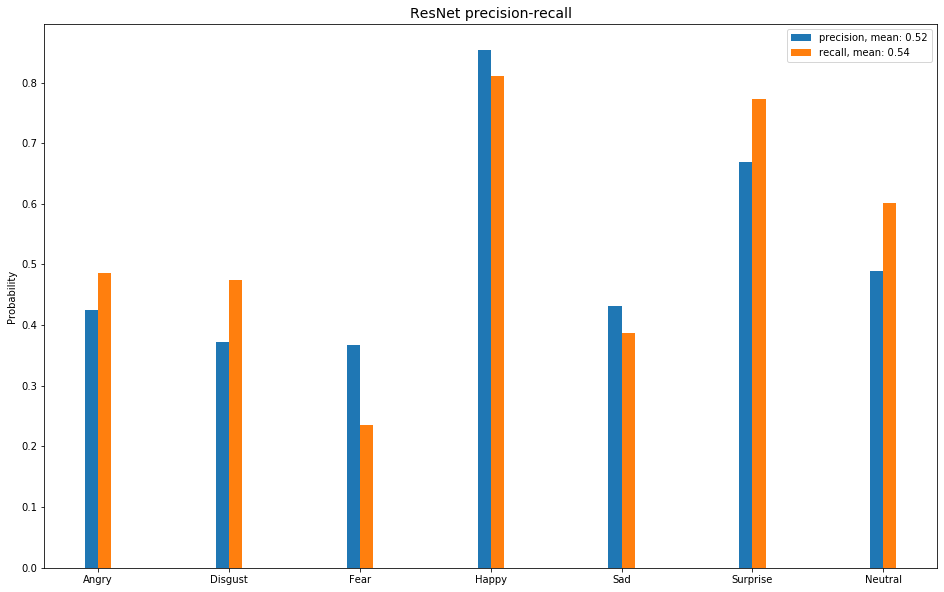

In [14]:
y_true = [element.detach().cpu().numpy() for array in predictions for element in array['true']]
y_pred = [element.detach().cpu().numpy() for array in predictions for element in array['predictions']]
y_true = np.array(y_true)
y_pred = np.array(y_pred)
resnet_preds = y_pred.squeeze()
class_precisions, class_recalls = calculate_precision_recall(y_true, y_pred)

plot_result_barplot([class_precisions, class_recalls], 'ResNet precision-recall', ['precision', 'recall'], save_as='resnet-50-of-prec-recall', figsize=(16,10))

From the plots we see that precision and recall are often closely related. However on disgust it seems like our classifier is exeptionally good with recall. In training I used perfectly balanced weights on inverse to class proportion, so this might have emphasized the prediction of disgust more than necessary. 

**Misclassifications**

Let's inspect what misclassifications are the most common. Does the model mix angry and fearful expression? Let's take a look.

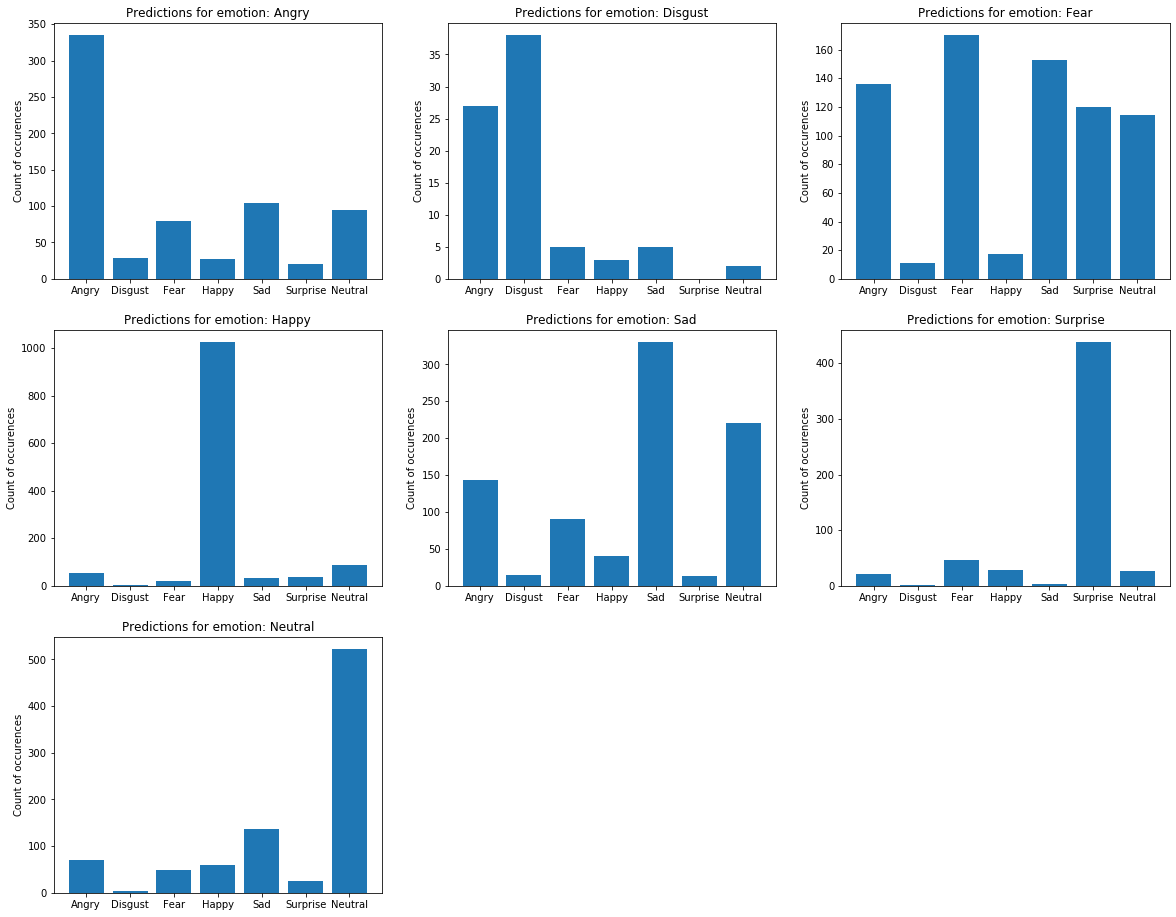

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
i = 0
j = 0
for category in range(N_FEATURES):
    class_indices = np.where(y_true == category)[0]
    preds = y_pred[class_indices]
    
    preds_hist = np.histogram(preds, bins=N_FEATURES)[0]
    ax[i, j].set_title(f"Predictions for emotion: {EMOTION_LIST[category]}")
    ax[i, j].bar(EMOTION_LIST, preds_hist)
    ax[i, j].set_ylabel("Count of occurences")
    
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0

ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.savefig(FIGURE_PATH + 'emotion-prediction-of-distributions.png')

We see that hard emotions for humans are also hard for the network - Anger and fearness tend to mix between each other, and also sad and neutral.

#### Let's investige whether we find the reason why these feelings tend to mix

Lime is great for easy and fast prediction summarization, but it has its own drawbacks. Lime uses linear predictors to define which local areas are significant for predicting the value. This assumes that the local areas have linear predictability, which might not be true in the real world.

In [16]:
from lime import lime_image

In [17]:
explainer = lime_image.LimeImageExplainer()

Lime doesn't work with pytorch out of the box, because it expects numpy array. We need to create our own batch generator function which processes the image.

In [18]:
def torch_image_to_tensor(im):
    image = im.permute(1,2,0).numpy()
    image = image.astype(np.double)
    return image
    
def single_image_predict(imgs):
    torch_image = torch.tensor(imgs)
    torch_image = torch_image.type(torch.FloatTensor)
    torch_image = torch_image.permute(0,3,1,2)
    imgs = torch_image.to(device)

    logits = resnet(imgs)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Load all of the images to pick certain label to describe

In [19]:
torch_images = next(iter(test_loader))[0]

In [20]:
explanations = []
for img in torch_images:
    single_image = torch_image_to_tensor(img)
    explanation = explainer.explain_instance(single_image, single_image_predict, num_samples=3000)
    explanations.append(explanation)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Visualize prediction. Only show what areas affect prediction positively with green, and negatively with red.

Images are normalized for CNN, so we need to do inverse_normalization to get clearer images

In [21]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


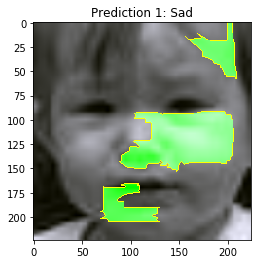

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


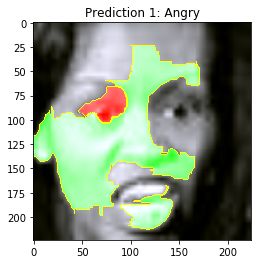

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


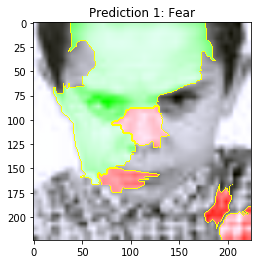

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


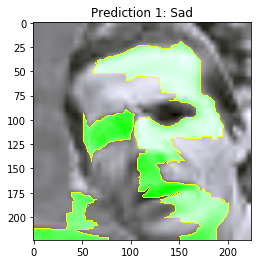

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


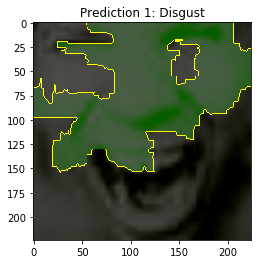

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


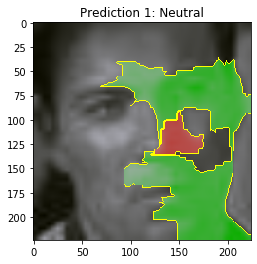

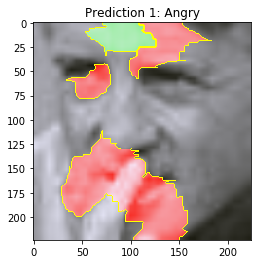

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


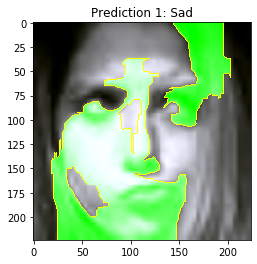

In [22]:
from skimage.segmentation import mark_boundaries

for i, explanation in enumerate(explanations):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                                num_features=7, hide_rest=False)
    temp_tensor = inv_normalize(torch.tensor(temp).permute(2,0,1)) # Convert to shape (3, 224, 224) for torch
    temp = temp_tensor.permute(1,2,0).numpy() # Flip image back to shape (224, 224, 3) and set as np.ndarray
    img_boundry1 = mark_boundaries(temp, mask, mode='inner')
    plt.figure()
    plt.imshow(img_boundry1)
    plt.title(f"Prediction 1: {EMOTION_LIST[explanation.top_labels[0]]}")
    plt.savefig(f'../reports/figures/pred_{EMOTION_LIST[explanation.top_labels[0]]}_true_angry_{i}')
    plt.show()

### Traditional models

The performance and explainability is a whole different topic with the other models that I trained. Now as the input images are turned in to embeddings, we can't define the 

Define the order in which the models are stored. This will be hard coded, and depends on the order that the models are stored in folder. This is risky if it would be put to production, but in this case it's just for convenience.

In [23]:
model_names = ['knn', 'LR', 'rbf-SVC', 'SGD', 'linear-SVC', 'XGBoost']

**EfficientNet embeddings** *NOTE:* loading the embeddings might take a minute.

In [24]:
X_train_embed, y_train_cnn = load_cnn_embedding('train')
X_test_embed, y_test_cnn = load_cnn_embedding('test')
X_val_embed, y_val_cnn = load_cnn_embedding('val')

pca, X_train_cnn, X_test_cnn, X_val_cnn = fit_pca(X_train_embed, X_test_embed, X_val_embed, n_components=200)

**PCA embeddings**

In [25]:
pca, X_train_pca, X_test_pca, X_val_pca = fit_pca(X_train, X_test, X_val, n_components = 50)

**HoG embeddings**

In [26]:
from skimage.feature import hog
from skimage import data, exposure

ppc = 10
train_imgs = [hog(x, orientations=8, pixels_per_cell=(ppc, ppc)) for x in X_train]
test_imgs = [hog(x, orientations=8, pixels_per_cell=(ppc, ppc)) for x in X_test]
val_imgs = [hog(x, orientations=8, pixels_per_cell=(ppc, ppc)) for x in X_val]

X_train_hog = np.vstack(train_imgs)
X_test_hog = np.vstack(test_imgs)
X_val_hog = np.vstack(val_imgs)

**Do predictions**

In [ ]:
cnn_predictions = [{model_names[i]: model.predict(X_test_cnn)} for i, model in enumerate(cnn_models)]
pca_predictions = [{model_names[i]: model.predict(X_test_pca)} for i, model in enumerate(pca_models)]
hog_predictions = [{model_names[i]: model.predict(X_test_hog)} for i, model in enumerate(hog_models)]

**Calculate precision-recall**

Utility function

In [ ]:
def plot_precision_recall(predictions, name):
    values = [list(*clf.values()) for clf in predictions]
    names = [list(clf.keys())[0] for clf in predictions]

    class_precisions = [calculate_precision_recall(y_test_cnn, y_p)[0] for y_p in values]
    class_recalls = [calculate_precision_recall(y_test_cnn, y_p)[1] for y_p in values]
    
    print(class_precisions)
    plot_result_barplot(class_precisions, f'Precision with {name} features', model_names=names, 
                        figsize=(16,6), save_as=f'traditional_precisions_{name}.png')
    plot_result_barplot(class_recalls, f'Recall with {name} features', model_names=names, 
                        figsize=(16,8), save_as=f'traditional_recalls_{name}.png')

CNN features

In [ ]:
plot_precision_recall(cnn_predictions, 'CNN')

PCA features

In [ ]:
plot_precision_recall(pca_predictions, 'PCA')

HOG features

In [ ]:
plot_precision_recall(hog_predictions, 'HOG')

### Calculate F1 score for each model

F1-score is a great balance between precision and recall. We can evaluate it on every classifier to see how well they compare against each other

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
cnn_scores = [f1_score(list(*y_p.values()), y_test_cnn, average='weighted') for y_p in cnn_predictions]
pca_scores = [f1_score(list(*y_p.values()), y_test, average='weighted') for y_p in pca_predictions]
hog_scores = [f1_score(list(*y_p.values()), y_test, average='weighted') for y_p in hog_predictions]
resnet_scores = f1_score(resnet_preds, y_test, average='weighted')

In [ ]:
fig = plt.figure(figsize=(14,7))
width = 0.15
plt.title("F1 scores", fontsize=18)
plt.bar(np.arange(6), cnn_scores, width, label="CNN")
plt.bar(np.arange(6) + width, pca_scores, width, label="PCA")
plt.bar(np.arange(6) + 2*width, hog_scores, width, label="HOG")
# plt.bar(np.arange(6) + 3*width + 0.3*width, resnet_scores, width, label="RESNET")
plt.xticks(np.arange(N_FEATURES) + width / 2, model_names)
plt.ylabel("Probability")
plt.xlabel("Classifier")
plt.legend(loc='best')
plt.savefig('../reports/figures/traditional_f1.png')

It seems like linear regression with CNN embeddings tend to work well. Linear regression is also the fastest algorithm among these, so it provides nice results in conclusion.

### Ensembles

Let's see whether we could improve performance by aggregating all of the classifiers, and getting ensemble predictions. Theory behind ensemble models is that each model would train independently, thus each model could possibly complement the other models predictions.

Define function that takes the majority vote on columns. This is the same as taking majority vote on classifier outputs for each sample.

In [ ]:
def most_frequent(x):
    return np.bincount(x).argmax()

def calculate_majority_voting(predictions, np_array=False):
    if not np_array:
        predictions = np.array([list(*y_p.values()) for y_p in predictions]).astype(int)
    embed_preds = np.apply_along_axis(most_frequent, 0, predictions)
    return embed_preds


In [ ]:
cnn_embed_predictions = calculate_majority_voting(cnn_predictions)
pca_embed_predictions = calculate_majority_voting(pca_predictions)
hog_embed_predictions = calculate_majority_voting(hog_predictions)

cnn_embed_f1 = f1_score(cnn_embed_predictions, y_test_cnn, average='weighted')
pca_embed_f1 = f1_score(pca_embed_predictions, y_test, average='weighted')
hog_embed_f1 = f1_score(hog_embed_predictions, y_test, average='weighted')
print(f"""
F1-score for majority votes, 
CNN: {round(cnn_embed_f1, 2)}, 
PCA: {round(pca_embed_f1, 2)},
HOG: {round(hog_embed_f1, 2)}
       """)

fig = plt.figure(figsize=(12,7))
width = 0.15
plt.title("F1 scores", fontsize=18)
plt.bar(np.arange(6), cnn_scores, width, label="CNN")
plt.bar(np.arange(6) + width, pca_scores, width, label="PCA")
plt.bar(np.arange(6) + 2*width, hog_scores, width, label="HOG")
plt.bar(np.arange(6) + 3*width + 0.3*width, resnet_scores, width, label="RESNET")
plt.xticks(np.arange(N_FEATURES) + width / 2, model_names)
plt.ylabel("Probability")
plt.xlabel("Classifier")
plt.legend(loc='best')


It seems like each prediction got slightly higher scores than individually. We can then try taking ensemble of all models.

In [ ]:
all_preds = np.vstack([cnn_embed_predictions, pca_embed_predictions, hog_embed_predictions, resnet_preds])
all_embed_preds = calculate_majority_voting(all_preds, np_array=True)
all_embed_f1 = f1_score(all_embed_preds, y_test, average='weighted')
print(f"F1-score for majority voting of all classifiers: {round(all_embed_f1, 2)}")

## Project evaluation metrics

**Project will be evaluated based on accuracy, so now we must calculate it**

**ensemble**

In [ ]:
from sklearn.metrics import accuracy_score
ensemble_accuracy = accuracy_score(y_test, all_embed_preds)


In [ ]:
[accuracy_score(y_test, x) for x in cnn_pr]